# Portofolio: RFM Analysis - Optimize Business Strategy using Customer Data Analysis

## Business Understanding

### Introduction

RFM analysis is a method used to analyze customer behaviour using recency, frequency, and monetary where recency answers when is the latest purchase each customer, frequency answers how many times each customer buy products, and monetary answers how much money each customer spend to buy products. 

RFM analysis helps us to increase customer retention, optimize marketing campigns, and identify which customers has high value.

### Dataset and Tools needed

We well use seblak prasmanan database. Seblak prasmanan is one of the new traditional Indonesian food. It's a boiled krupuk with various topping and what make seblak prasmanan special is you can take only topping that you like as many as you want.

This analysis is using POSTGRESQL as the main tool to process the data and the RFM analysis. We will not use all variables to analyze. We only need the id_customer, transaction_date, and money_spent.

### The Methodology

So far, we knew that we need are id_customer, transaction_date, and money_spent. Let's see the metrics we need and how to calculate it:
- To find the recency score, we need to calculate today date minus the newest date the customers bought. For example, customer 03 bought something in '03-04-2023' and today is '06-04-2024'. It means '06-04-2024' - '03-04-2024' = 3 days. The smaller day you get, the better you get score. that's recency.
- To find the frequency score, you just need to count how many times the customers buy. This must be the easiest calculation in RFM analysis.
- To find the monetary is sometimes tricky. Monetary means how much money they spent to buy our products. In this case, we use 'jumlah' variable (which means amount) multiple by 'harga_jual_satuan' (which means price per item).

After that, we will separate them into three categories for each metrics. Recency will get low, medium, and high category. Also the same with Frequency and Monetary. To make it easier to calculate, we will use 1 for low, 2 for medium, and 3 for high.

Finally, we will give weight for each metrics. In this example, we will give weight 20% for recency, 35% for frequency, and 45% for monetary. And then sum them up.

## Data Understanding

### Load Library and Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv('data/rfm_analysis.csv')
print(dataset.head())

   id_pelanggan tanggal_transaksi  jumlah
0             1        2024-01-01   47000
1             4        2024-01-01  189000
2             9        2024-01-01   78500
3            12        2024-01-01   80000
4            20        2024-01-01   90000


### Data Profiling

In [3]:
# column type
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109566 entries, 0 to 109565
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id_pelanggan       109566 non-null  int64 
 1   tanggal_transaksi  109566 non-null  object
 2   jumlah             109566 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ MB


In [4]:
# missing value
dataset.isnull().sum()

id_pelanggan         0
tanggal_transaksi    0
jumlah               0
dtype: int64

In [5]:
# duplicated value
dataset.duplicated().sum()

np.int64(0)

NOTE:
- tanggal_transaksi which means datetime is still an object. we can change data format in preprocessing section.
- the data has no missing value
- the data has no duplicated value

### Descriptive Statistics

In [6]:
dataset['tanggal_transaksi'].value_counts()

tanggal_transaksi
2024-04-03    579
2024-06-17    552
2024-10-10    543
2024-10-11    542
2024-03-08    534
             ... 
2024-05-12     10
2024-07-06      9
2024-04-17      8
2024-02-18      6
2024-08-10      1
Name: count, Length: 366, dtype: int64

NOTE:
- 2024-04-03 is the date with the highest transaction, totalling 579.
- 2024-08-10 is the date with the least transaction, totalling 1 transaction.

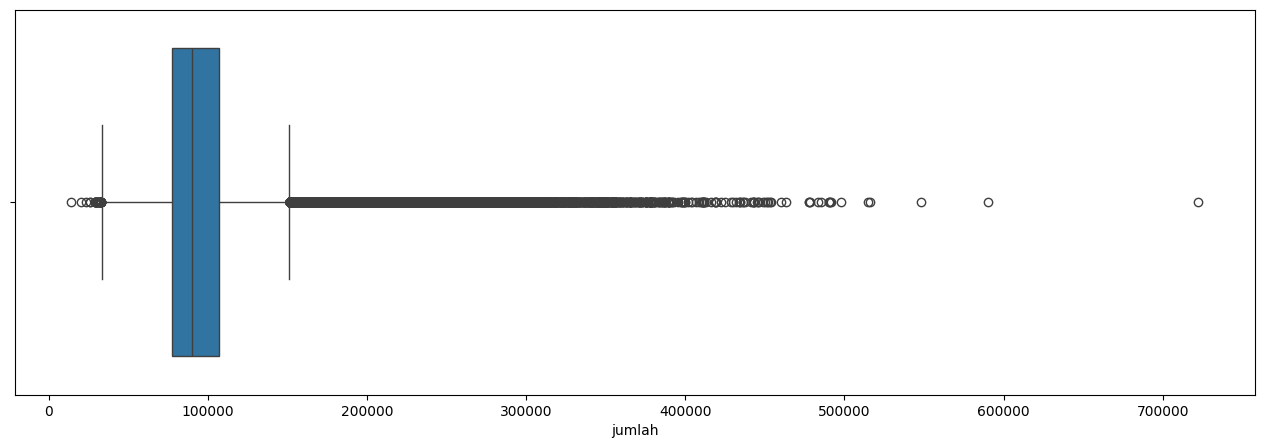

count    109566.000
mean     104435.687
std       46556.029
min       14000.000
25%       77500.000
50%       90000.000
75%      107000.000
max      722500.000
Name: jumlah, dtype: float64


In [7]:
plt.figure(figsize=(16,5))
sns.boxplot(dataset['jumlah'],orient='h')
plt.show()
print(dataset['jumlah'].describe().round(3))

NOTE:
- from the boxplot, we can see that the distribution is right-skewed distribution where the mean is pulled by the highest value and the mean is close to Q3. we can assume that the data is not normally distributed.
- there are so much outliers where they spent money more than the average customers.

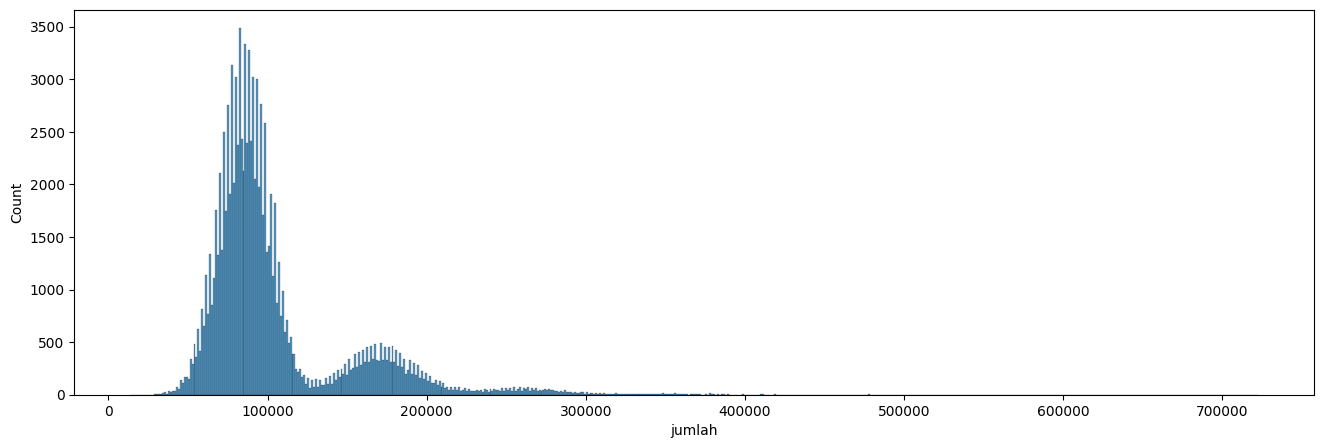

In [8]:
plt.figure(figsize=(16,5))
sns.histplot(dataset['jumlah'])
plt.show()

NOTE:

- we can see from the figure that the variable has two peaks which is called bimodal distribution.
- they have two behaviour of spending money. some around 90000, some around 170000. i forgot to tell you that the currency is IDR (Indonesian Rupiah).
- further analysis: try seeing the trend over month.

## Data Preprocessing

In [9]:
dataset['tanggal_transaksi'] = pd.to_datetime(dataset['tanggal_transaksi'])

In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109566 entries, 0 to 109565
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id_pelanggan       109566 non-null  int64         
 1   tanggal_transaksi  109566 non-null  datetime64[ns]
 2   jumlah             109566 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.5 MB


In [11]:
print(dataset.tail())

        id_pelanggan tanggal_transaksi  jumlah
109561          1422        2024-12-31   93000
109562          1425        2024-12-31   84500
109563          1428        2024-12-31   72500
109564          1429        2024-12-31   93500
109565          1431        2024-12-31  108500


In [12]:
monetary = dataset.groupby('id_pelanggan')['jumlah'].sum()
recency = dataset['tanggal_transaksi'].max() - dataset.groupby('id_pelanggan')['tanggal_transaksi'].max()
frequency = dataset.groupby('id_pelanggan')['id_pelanggan'].count()

In [13]:
pivot_dataset = pd.concat([recency, frequency, monetary], axis=1)

In [14]:
pivot_dataset.keys()

Index(['tanggal_transaksi', 'id_pelanggan', 'jumlah'], dtype='object')

In [15]:
pivot_dataset.rename(columns={'tanggal_transaksi':'recency',
                              'id_pelanggan': 'frequency',
                              'jumlah': 'monetary'}, inplace=True)

In [16]:
print(pivot_dataset.head())

             recency  frequency  monetary
id_pelanggan                             
1             2 days        119  14113000
2             0 days        138  15390000
3             0 days         86   8584000
4             1 days        117  13237000
5             1 days        130  14195000


## Modeling

In [17]:
pivot_dataset['recency_score'] = pivot_dataset['recency'].rank(ascending=False)
pivot_dataset['frequency_score'] = pivot_dataset['frequency'].rank(ascending=True)
pivot_dataset['monetary_score'] = pivot_dataset['monetary'].rank(ascending=True)
pivot_dataset['recency_segment'] = pd.qcut(x=pivot_dataset['recency_score'], q=3, labels=[1, 2, 3]).astype('int')
pivot_dataset['frequency_segment'] = pd.qcut(x=pivot_dataset['frequency_score'], q=3, labels=[1, 2, 3]).astype('int')
pivot_dataset['monetary_segment'] = pd.qcut(x=pivot_dataset['monetary_score'], q=3, labels=[1, 2, 3]).astype('int')
pivot_dataset['rfm_score'] = (((pivot_dataset['recency_segment']*0.2)+(pivot_dataset['frequency_segment']*0.3)+(pivot_dataset['monetary_segment']*0.5))/3*100).round()
pivot_dataset['rfm_segment'] = pivot_dataset['recency_segment'].astype('str') + pivot_dataset['frequency_segment'].astype('str') + pivot_dataset['monetary_segment'].astype('str')
print(pivot_dataset.head())

             recency  frequency  monetary  recency_score  frequency_score  \
id_pelanggan                                                                
1             2 days        119  14113000          737.5           1179.0   
2             0 days        138  15390000         1224.0           1400.5   
3             0 days         86   8584000         1224.0            779.5   
4             1 days        117  13237000          921.5           1150.5   
5             1 days        130  14195000          921.5           1319.5   

              monetary_score  recency_segment  frequency_segment  \
id_pelanggan                                                       
1                     1278.0                2                  3   
2                     1379.0                3                  3   
3                      772.0                3                  2   
4                     1190.0                2                  3   
5                     1288.0                2       

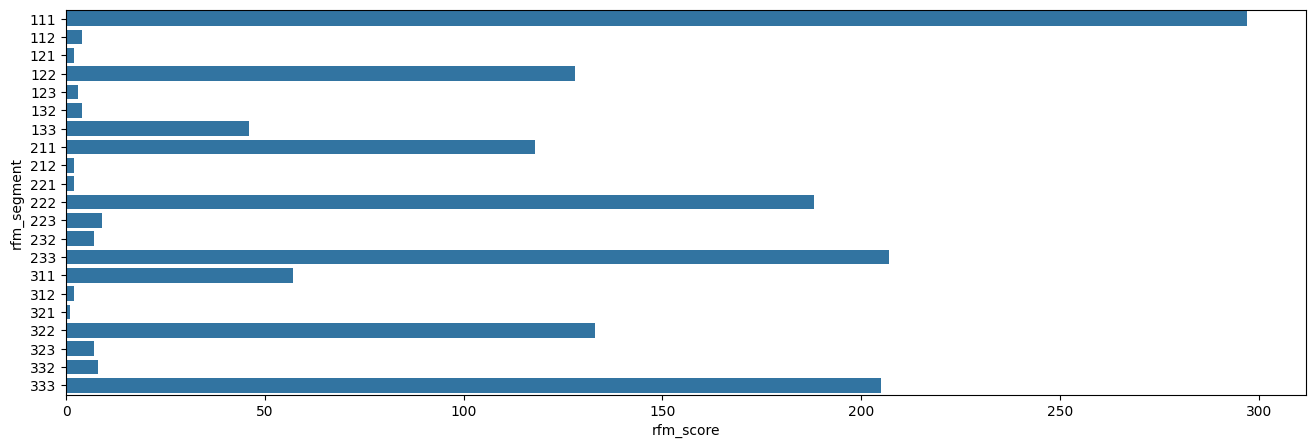

In [18]:
plt.figure(figsize=(16,5))
sns.barplot(pivot_dataset.groupby('rfm_segment')['rfm_score'].count(), orient='h')
plt.show()

In [19]:
pivot_dataset.groupby(['rfm_score','rfm_segment'])['rfm_score'].count()

rfm_score  rfm_segment
33.0       111            297
40.0       211            118
43.0       121              2
47.0       311             57
50.0       112              4
           221              2
57.0       212              2
           321              1
60.0       122            128
63.0       312              2
67.0       222            188
70.0       132              4
73.0       322            133
77.0       123              3
           232              7
83.0       223              9
           332              8
87.0       133             46
90.0       323              7
93.0       233            207
100.0      333            205
Name: rfm_score, dtype: int64

## Insights

### Interpretation and Reporting

There are 205 customers that has score 100 which is excellent and we need to maintain it. There are 207 customers that gets score 93 and it will be more because we can lead 46 customers from low recency to medium recency.

There are 128 customers with low recency, 188 customers with medium recency, and 133 customers with high recency. Three of them are medium frequency and medium monetary.

There are 297 customers with low recency, 118 customers with medium recency, and 57 customers with high recency. Three of them are low frequency and low monetary.

The rest of the category are small groups. Let's focus on the big groups.

### Actions

For R3F3M3 segment is our top performers. These customers don't need unnecessary promo. Just give them retention campaign like loyalty rewards or vip discounts. They will probably love it.

For R2-R1F3M3 categories are our potential customers. They had high transaction and high frequency but had lost interest to our products. These customers need "we missed you" promo and limited time offer which is a big discount so they come back to our products. It needs to be highlighted that this promo cannot be bigger than the promo you gave to the top performers. Otherwise, they will feel jealous.

Finding new customers are always harder than winning past customers. So, although recency gets 20% weight of rfm analysis, recency is the most crucial process to retention. When the recency is high already (R3), continue to frequency strategy that make customer buy more often (F3). When it's done, doing some up-selling and cross-selling products to gain transaction (M3).

For R2-R1F2M2 categories, better do limited time offer so the customers instantly purchase our products. When they become R3F2M2, offer loyalty program like give them ten-empty-block card. When they purchase our products, they will get stamp and when the card is full of stamp, they get free product or food if it's foods and beverages. You can also offer discount for their next purchase for R3F1M1 category. 

For R1F1M1 category, they are past customers, rarely purchased, and spent small amount of money. Try giving broader promo that can apply for finding new customers and winning pas customers. Also make personalized promo to show them that we know them.

Categories:
- R2F3M3 (207 customers) focuses on limited time offer.
- R1F3M3 (46 customers) focuses on limited time offer.
- R3F2M2 (133 customers) focuses on loyalty program.
- R2F2M2 (188 customers) focuses on limited time offer.
- R1F2M2 (128 customers) focuses on limited time offer.
- R3F1M1 (57 customers) focuses on loyalty program.
- R2F1M1 (118 customers) focuses on limited time offer.

## Further Analysis

- Do survival analysis to understand customer lifetime value, predicting how often customers purchase.
- Do cohort analysis to understand retention rate, observing customer behaviour based on their first purchase.
- Do churn analysis to understand churn rate, identifying why customers stop purchasing or using our products.